# Example usage of py-wsi

Author: @ysbecca


In [1]:
import py_wsi

Set parameters for file directory of SVS images, patch size, level (magnification), and overlap.

In [2]:
file_dir = "/Users/ysbecca/ysbecca-projects/py_wsi/py_wsi/wsi_data/"
xml_dir = file_dir
patch_size = 256
level = 12
db_location = ""
db_name = "patch_db"
overlap = 0

# All possible labels mapped to integer ids in order of increasing severity.
label_map = {'Normal': 0,
             'Benign': 1,
             'Carcinoma in situ': 2,
             'In situ carcinoma': 2,
             'Carcinoma invasive': 3,
             'Invasive carcinoma': 3,
            }

Create a new py-wsi manager object for our collection of svs images. It's called a turtle.

In [3]:
turtle = py_wsi.Turtle(file_dir, db_location, db_name, xml_dir=xml_dir, label_map=label_map)

10 WSI found in directory.


The Turtle object keeps track of how many WSI images are in its collection, and the LMDB that stores the patches and their info.

In [4]:
print("Total WSI images:    " + str(turtle.num_files))
print("LMDB name:           " + str(turtle.db_name))
print("File names:          " + str(turtle.files))
print("XML files found:     " + str(turtle.get_xml_files()))

Total WSI images:    10
LMDB name:           patch_db
File names:          ['A01.svs' 'A02.svs' 'A03.svs' 'A04.svs' 'A05.svs' 'A06.svs' 'A07.svs'
 'A08.svs' 'A09.svs' 'A10.svs']
XML files found:     ['A01.svs' 'A02.svs' 'A03.svs' 'A04.svs' 'A05.svs' 'A06.svs' 'A07.svs'
 'A08.svs' 'A09.svs' 'A10.svs']


Sample patches now and store them in a new LMDB database. This actually creates two databases, one for the patches themselves and another for the image metadata, specifically, the tile dimensions. The second database is only used internally, for retrieving patches from the first database.

**load_xml=True** looks for XML files in the XML directory and labels patches according to any regions provided 
in the XML files.

In [11]:
turtle.sample_and_store_patches(patch_size, level, overlap, load_xml=True)

Creating new LMDB environment...
A01.svs A02.svs A03.svs A04.svs A05.svs A06.svs A07.svs A08.svs A09.svs A10.svs 
====== LMDB patch_db Stats ======
{'psize': 4096, 'depth': 2, 'branch_pages': 1, 'leaf_pages': 18, 'overflow_pages': 63994, 'entries': 1306}
====== LMDB patch_db_meta Stats ======
{'psize': 4096, 'depth': 1, 'branch_pages': 0, 'leaf_pages': 1, 'overflow_pages': 0, 'entries': 10}
Time usage: 0:03:43


Now we can create a Dataset object which loads all the patches from the LMDB. Alternatively, the turtle object can be used by any other dataset object or input format required for the next stage of processing.

In [4]:
import dataset as ds
import imagepy_toolkit

In [5]:
dataset = ds.read_datasets(turtle,
                set_id=1,
                valid_id=0,
                total_sets=5,
                shuffle_all=True,
                augment=False)

We can see the dataset information read in from the LMDB:

In [6]:
print("Total training set images:     " + str(len(dataset.train.images)))
print("Total validation set images:   " + str(len(dataset.valid.images)))

Total training set images:     239
Total validation set images:   270


And can view some of the original patches (using a helper function from [imagepy-toolkit](https://github.com/ysbecca/imagepy-toolkit)):

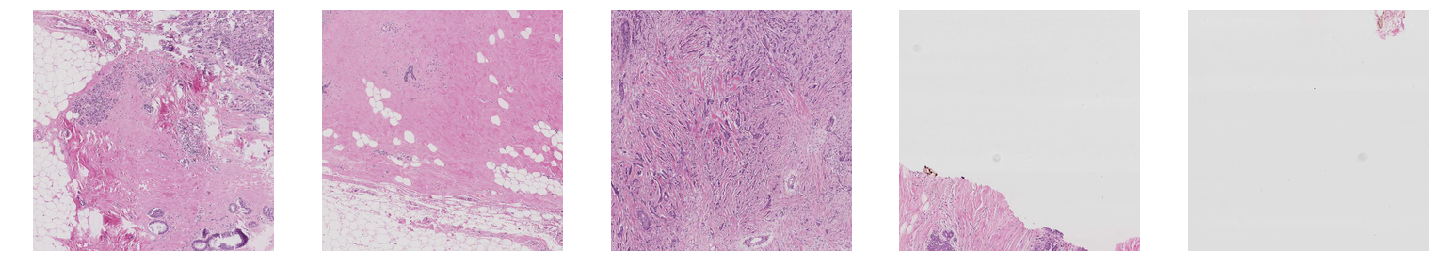

In [7]:
imagepy_toolkit.show_images(dataset.train.images, 5, 1)

We can also view the labels associated with these patches.

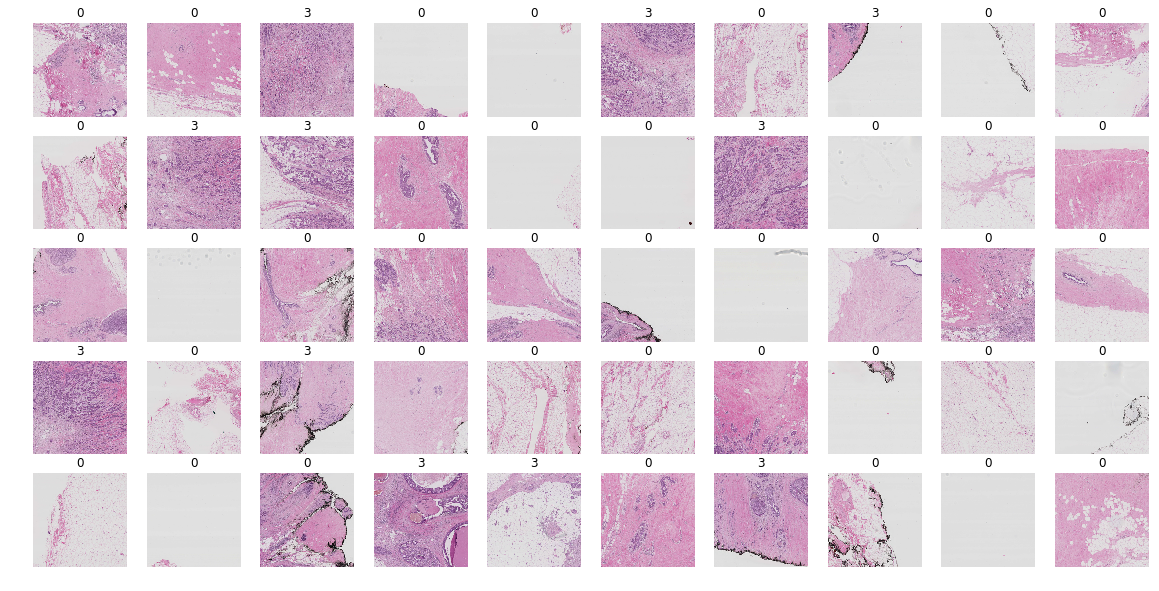

In [11]:
imagepy_toolkit.show_labeled_patches(dataset.train.images, dataset.train.image_cls)